用于比较和测试 Python 主流缓存库的性能表现。

### 主要库对比

- functools.lru_cache: 标准库 LRU 缓存。
- [cachetools](https://github.com/tkem/cachetools): 纯 Python 缓存实现。
- [cachebox](https://github.com/awolverp/cachebox): 用 Rust 编写的缓存实现。
- [lru-dict](https://github.com/amitdev/lru-dict): 用 C 编写的 LRU 缓存。

### 测试内容

通过基准测试（Benchmark）对两个缓存库进行性能评估，包括：
- 缓存命中场景的执行时间
- TTL 过期后的缓存重新填充性能
- 不同样本批次的性能表现

In [ ]:
!pip install matplotlib numpy

`plot_performance_comparison` 通过 matplotlib 生成对比结果的可视化图表。

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

def human_readable_time(x, _):
    if x < 1e-3:
        return f"{x * 1e6:.0f} µs"
    elif x < 1:
        return f"{x * 1e3:.0f} ms"
    elif x < 60:
        return f"{x:.2f} s"
    else:
        return f"{x / 60:.1f} min"

def plot_performance_comparison(batch_sizes: list[int], results: dict[str, list[float]],
                                *, title: str = "Performance Comparison", x_label: str = "Number of Samples", y_label: str = "Time"):
    libraries = list(results.keys())
    num_libs = len(libraries)
    num_batches = len(batch_sizes)

    x = np.arange(num_batches)
    bar_width = 0.8 / num_libs

    _, ax = plt.subplots(figsize=(10, 6))

    for i, lib in enumerate(libraries):
        offsets = x + i * bar_width
        bars = ax.bar(offsets, results[lib], width=bar_width, label=lib)

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height,
                    human_readable_time(height, None), ha="center", va="bottom", fontsize=9)

    ax.set_xticks(x + bar_width * (num_libs - 1) / 2)
    ax.set_xticklabels([str(b) for b in batch_sizes])

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

    ax.yaxis.set_major_formatter(FuncFormatter(human_readable_time))

    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

通过实现并测试 `cachetools` 和 `cachebox` 的时效性缓存（TTL）功能，比较两者的性能表现。具体操作包括：为每个库实现一个模拟耗时函数，随后分析并展示两者的执行时间。

---

## 安装依赖库

安装 `cachetools` 和 `cachebox` 库。


In [2]:
!pip install cachetools cachebox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.3/411.3 kB 16.9 MB/s eta 0:00:00


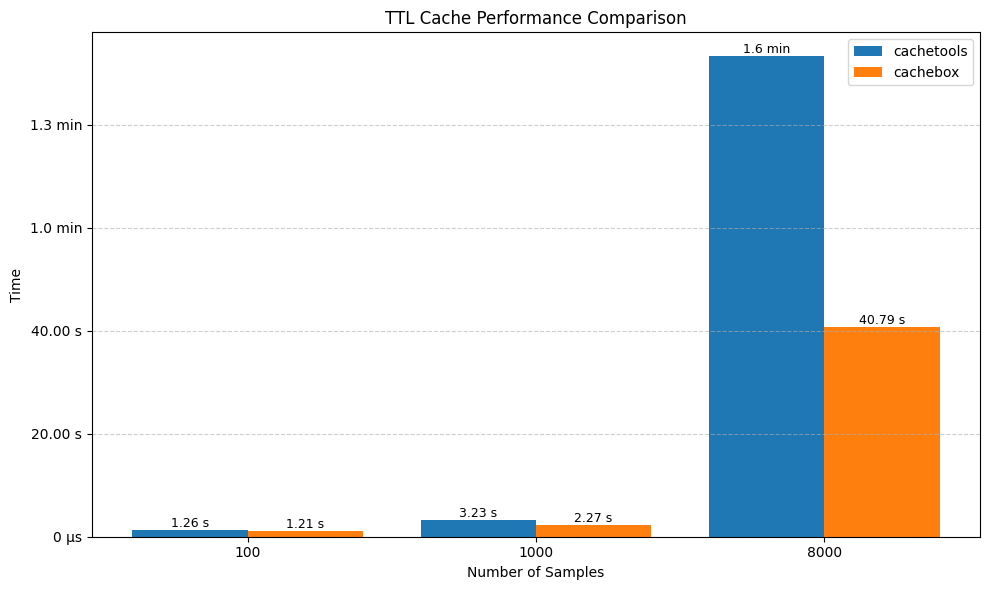

In [ ]:
import time
import timeit

batch_sizes = [100, 1000, 8000]
ttl_benchmark_results = {"cachetools": [], "cachebox": []}

def ct_ttl_benchmark(samples):
    from cachetools import TTLCache, cached
    @cached(TTLCache(maxsize=1024, ttl=1))
    def work(x: int) -> int:
        return x * x

    # 预热，用于模拟测试缓存命中、TTL 计算过期的缓存移除与缓存移除后的插入
    _ = [work(i) for i in range(samples)]

    def benchmark_hit():
        _ = [work(i) for i in range(samples)]
    def benchmark_expired():
        time.sleep(1.1)
        _ = [work(i) for i in range(samples)]

    hit_time = timeit.timeit(benchmark_hit, number=1000)
    expired_time = timeit.timeit(benchmark_expired, number=1)
    ttl_benchmark_results["cachetools"].append(hit_time + expired_time)

def cb_ttl_benchmark(samples):
    import cachebox
    @cachebox.cached(cachebox.TTLCache(maxsize=1024, ttl=1))
    def work(x: int) -> int:
        return x * x

    # 预热，用于模拟测试缓存命中、TTL 计算过期的缓存移除与缓存移除后的插入
    _ = [work(i) for i in range(samples)]

    def benchmark_hit():
        _ = [work(i) for i in range(samples)]
    def benchmark_expired():
        time.sleep(1.1)
        _ = [work(i) for i in range(samples)]

    hit_time = timeit.timeit(benchmark_hit, number=1000)
    expired_time = timeit.timeit(benchmark_expired, number=1)
    ttl_benchmark_results["cachebox"].append(hit_time + expired_time)


for samples in batch_sizes:
    ct_ttl_benchmark(samples)
    cb_ttl_benchmark(samples)

plot_performance_comparison(batch_sizes=batch_sizes, results=ttl_benchmark_results,
                            title="TTL Cache Performance Comparison")

通过实现并测试测试 Python 生态中常见的 LRU 类缓存实现。

- std (`functools.lru_cache`)
- cachetools
- cachebox
- lrudict
---

## 安装依赖库

安装 `lru-dict` 库。

In [3]:
!pip install lru-dict

--- 缓存性能对比 (样本数: 10000), 迭代次数 = 100 ---
Standard lru_cache:   0.1423s
Cachetools LRUCache:  3.2106s
CacheBox LRUCache:  2.7891s
lrudict:  0.1921s
--- 缓存性能对比 (样本数: 500000), 迭代次数 = 5 ---
Standard lru_cache:   0.6904s
Cachetools LRUCache:  11.3809s
CacheBox LRUCache:  11.1308s
lrudict:  1.2840s
--- 缓存性能对比 (样本数: 100000), 迭代次数 = 50 ---
Standard lru_cache:   0.9451s
Cachetools LRUCache:  21.7387s
CacheBox LRUCache:  19.5448s
lrudict:  1.5688s


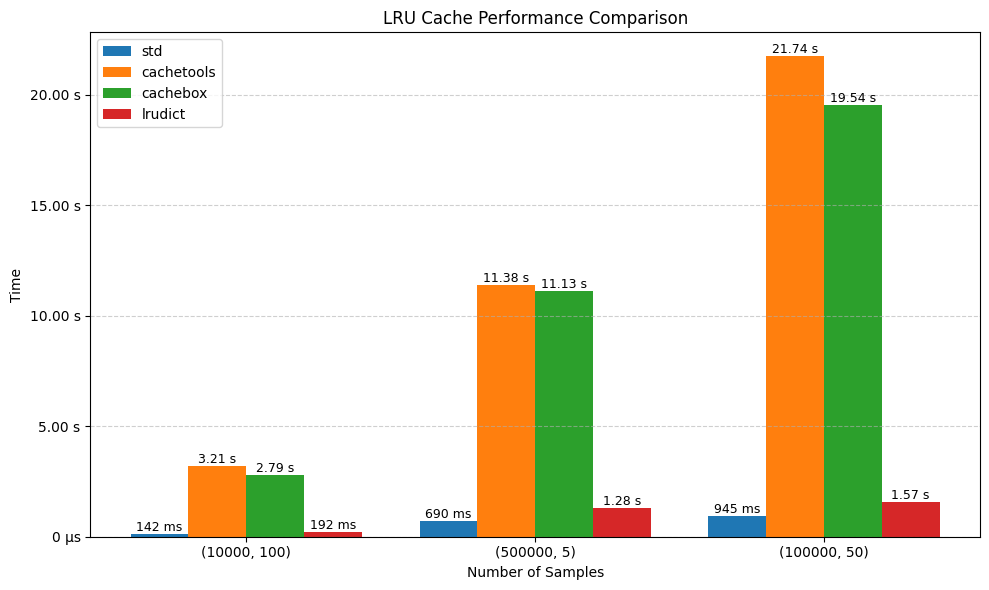

In [9]:
import random
import timeit

batch_sizes = [
    (10_000, 100),  # 微基准测试
    (500_000, 5),   # GC 压力测试
    (100_000, 50),  # 生产模拟
]
lru_benchmark_results = {"std": [], "cachetools": [], "cachebox": [], "lrudict": []}

def run_lrucache_benchmark(samples, iterations = 100, cache_maxsize=1024):
    print(f"--- 缓存性能对比 (样本数: {samples}), 迭代次数 = {iterations} ---")

    # 准备数据
    pool = [f"key_{i}" for i in range(samples)]
    hot_size = int(samples * 0.2)
    data = random.choices(pool[:hot_size], k=samples-hot_size) + random.choices(pool, k=hot_size)
    random.shuffle(data)

    # 标准库 lru 基准测试
    from functools import lru_cache
    def std_lru_benchmark():
        @lru_cache(maxsize=cache_maxsize)
        def get_value(key):
            return key
        for i in data:
            _ = get_value(i)
    t1 = timeit.timeit(std_lru_benchmark, number=iterations)
    lru_benchmark_results["std"].append(t1)
    print(f"Standard lru_cache:   {t1:.4f}s")

    # cachetools lru 基准测试
    from cachetools import LRUCache, cached
    def ct_lru_benchmark():
        @cached(cache=LRUCache(maxsize=cache_maxsize))
        def get_value(key):
            return key
        for i in data:
            _ = get_value(i)
    t2 = timeit.timeit(ct_lru_benchmark, number=iterations)
    lru_benchmark_results["cachetools"].append(t2)
    print(f"Cachetools LRUCache:  {t2:.4f}s")

    # cachebox lru 基准测试
    import cachebox
    def cb_lru_benchmark():
        @cachebox.cached(cachebox.LRUCache(maxsize=cache_maxsize))
        def get_value(key):
            return key
        for i in data:
            _ = get_value(i)
    t3 = timeit.timeit(cb_lru_benchmark, number=iterations)
    lru_benchmark_results["cachebox"].append(t3)
    print(f"CacheBox LRUCache:  {t3:.4f}s")

    # lrudict 基准测试
    from lru import LRU
    def cb_lru_benchmark():
        l = LRU(cache_maxsize)
        def get_value(key):
            if key in l:
                return l[key]
            v = key
            l[key] = v
            return v
        for i in data:
            _ = get_value(i)
    t4 = timeit.timeit(cb_lru_benchmark, number=iterations)
    lru_benchmark_results["lrudict"].append(t4)
    print(f"lrudict:  {t4:.4f}s")

for samples, iterations in batch_sizes:
    run_lrucache_benchmark(samples, iterations=iterations)

plot_performance_comparison(batch_sizes=batch_sizes, results=lru_benchmark_results,
                            title="LRU Cache Performance Comparison")